<a href="https://colab.research.google.com/github/DwiBagiaSantosa/C23-PS117/blob/ml/notebooks/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Dataset

In [ ]:
!pip install gdown -q

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pathlib
import numpy as np
import matplotlib.pylab as plt

In [ ]:
# download dataset

!gdown 'https://drive.google.com/uc?id=1mHgYW8AWVe4WTpxk95GmeuWESXAM0KJp' -O cleaned_dataset.zip
!unzip -q cleaned_dataset.zip
!mv /content/content/dataset /content
!rm -rf /content/content

Downloading...
From: https://drive.google.com/uc?id=1mHgYW8AWVe4WTpxk95GmeuWESXAM0KJp
To: /content/cleaned_dataset.zip
100% 248M/248M [00:05<00:00, 44.1MB/s]


In [ ]:
dataset_dir = "/content/dataset"
train_dir = "/content/dataset/train"
valid_dir = "/content/dataset/dev"
test_dir = "/content/dataset/test"

In [ ]:
handle_base, pixels, FV_SIZE = ("mobilenet_v2", 224, 1280)
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)

print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


# ImageGenerator

In [ ]:
BATCH_SIZE = 64 

In [ ]:
# Datagen
train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen =  ImageDataGenerator(rescale=1./255)

# Flow training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

# Flow validation data generator
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

# Flow test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 16100 images belonging to 23 classes.
Found 3450 images belonging to 23 classes.
Found 3450 images belonging to 23 classes.


In [ ]:
class_names = list(train_generator.class_indices.keys())

# Create a label.txt file with the class names

with open('label.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [ ]:
feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape=IMAGE_SIZE + (3,), 
    output_shape=[FV_SIZE],
    trainable=False
)

In [ ]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 23)                11799     
                                                                 
Total params: 2,925,655
Trainable params: 667,671
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model using MobileNet v2

In [ ]:
from keras import callbacks

early_stop = callbacks.EarlyStopping(
    monitor="val_loss", 
    mode="min",
    patience=3,
    restore_best_weights=True
)

In [ ]:
EPOCHS = 10

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/10
252/252 [==============================] - 951s 4s/step - loss: 1.1119 - accuracy: 0.6715 - val_loss: 0.8639 - val_accuracy: 0.7374
Epoch 2/10
252/252 [==============================] - 940s 4s/step - loss: 0.7537 - accuracy: 0.7693 - val_loss: 0.8371 - val_accuracy: 0.7441
Epoch 3/10
252/252 [==============================] - 979s 4s/step - loss: 0.6468 - accuracy: 0.8007 - val_loss: 0.8409 - val_accuracy: 0.7449
Epoch 4/10
252/252 [==============================] - 922s 4s/step - loss: 0.5564 - accuracy: 0.8219 - val_loss: 0.8269 - val_accuracy: 0.7565
Epoch 5/10
252/252 [==============================] - 927s 4s/step - loss: 0.4859 - accuracy: 0.8413 - val_loss: 0.8166 - val_accuracy: 0.7539
Epoch 6/10
252/252 [==============================] - 915s 4s/step - loss: 0.4205 - accuracy: 0.8622 - val_loss: 0.8365 - val_accuracy: 0.7597
Epoch 7/10
252/252 [==============================] - 918s 4s/step - loss: 0.3727 - accuracy: 0.8742 - val_loss: 0.9055 - val_accuracy: 0.7443

# Training Result

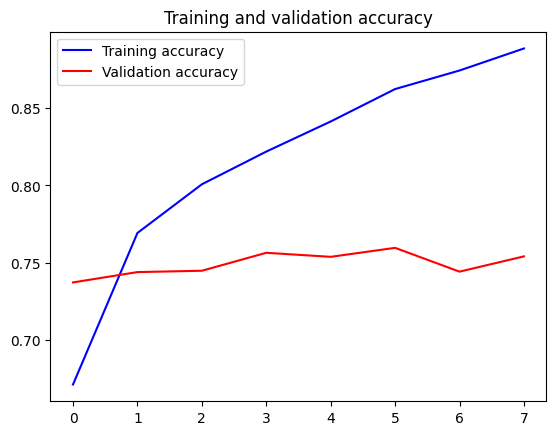

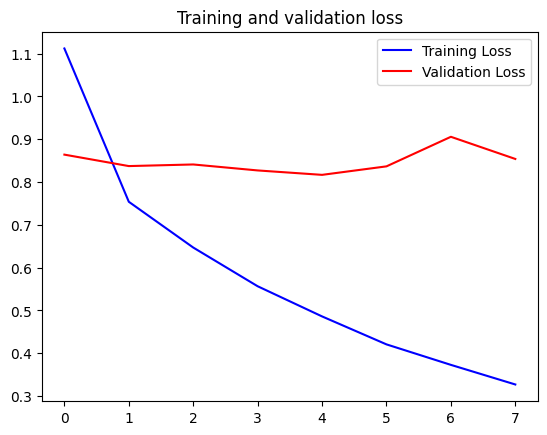

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate final score on Validation and Testing data

scores = model.evaluate(validation_generator)
scores = model.evaluate(test_generator)

54/54 [==============================] - 135s 2s/step - loss: 0.7231 - accuracy: 0.7757


# Results :
- Training : 84.13 %
- Validation : 75.39 %
- Test : 77.57 %

# Export and Convert Model to tflite

In [ ]:
model.save('model.h5')
model.save('model')
!zip -r 'model.zip' 'model'

  adding: model/ (stored 0%)
  adding: model/assets/ (stored 0%)
  adding: model/keras_metadata.pb (deflated 84%)
  adding: model/saved_model.pb (deflated 92%)
  adding: model/fingerprint.pb (stored 0%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: model/variables/variables.index (deflated 78%)


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('model')

# Set the optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# Invoke the converter to generate the TFLite model
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

3176904

# Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

54/54 [==============================] - 130s 2s/step
Classification Report
                precision    recall  f1-score   support

         bakso       0.92      0.93      0.93       150
         bread       0.49      0.52      0.50       150
    cheesecake       0.71      0.65      0.68       150
 chicken_wings       0.72      0.87      0.79       150
       churros       0.93      0.74      0.83       150
       dessert       0.55      0.43      0.48       150
        donuts       0.73      0.83      0.77       150
           egg       0.76      0.71      0.74       150
  french_fries       0.80      0.88      0.84       150
    fried_rice       0.78      0.91      0.84       150
          gado       0.84      0.91      0.88       150
     hamburger       0.78      0.81      0.79       150
       hot_dog       0.81      0.83      0.82       150
mac_and_cheese       0.76      0.81      0.78       150
      pancakes       0.64      0.70      0.67       150
         pizza       0.73  